In [0]:
import requests

# Replace with your GitHub file's raw URL
url = "https://raw.githubusercontent.com/reach2kapil/Data_Sets/main/flights.csv"
response = requests.get(url)

# Save the file locally first
temp_path = "/tmp/flights.csv"
with open(temp_path, "wb") as file:
    file.write(response.content)

# Copy the file to DBFS
dbutils.fs.cp(f"file:{temp_path}", "dbfs:/FileStore/flights.csv")

# Verify the file exists in DBFS
dbutils.fs.ls("dbfs:/FileStore/")


Out[13]: [FileInfo(path='dbfs:/FileStore/flights.csv', name='flights.csv', size=590, modificationTime=1732360471000),
 FileInfo(path='dbfs:/FileStore/tables/', name='tables/', size=0, modificationTime=0)]

In [0]:
# Use the dbfs:/ path for Spark
spark_file_path = "dbfs:/FileStore/flights.csv"
spark_df = spark.read.csv(spark_file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
spark_df.show()


+------------+------------------+------+-----------+-------------------+-------------------+--------+-----+
|FlightNumber|           Airline|Origin|Destination|      DepartureTime|        ArrivalTime|Duration|Price|
+------------+------------------+------+-----------+-------------------+-------------------+--------+-----+
|       AI101|         Air India|   DEL|        NYC|2024-11-20 22:00:00|2024-11-21 10:30:00| 15h 30m|  650|
|       EK501|          Emirates|   BOM|        DUB|2024-11-21 02:00:00|2024-11-21 05:30:00|  3h 30m|  450|
|       BA202|   British Airways|   LHR|        JFK|2024-11-20 17:00:00|2024-11-20 20:00:00|   8h 0m|  800|
|       LH303|         Lufthansa|   FRA|        ORD|2024-11-21 08:00:00|2024-11-21 12:30:00|  9h 30m|  700|
|       SQ305|Singapore Airlines|   SIN|        SFO|2024-11-22 23:00:00|2024-11-23 10:00:00|  17h 0m| 1200|
|       QR400|     Qatar Airways|   DOH|        SYD|2024-11-21 07:00:00|2024-11-21 19:30:00| 12h 30m|  950|
|       CX508|    Cathay Pac

In [0]:
spark_df.describe().show()

+-------+------------+------------------+------+-----------+--------+-----------------+
|summary|FlightNumber|           Airline|Origin|Destination|Duration|            Price|
+-------+------------+------------------+------+-----------+--------+-----------------+
|  count|           7|                 7|     7|          7|       7|                7|
|   mean|        null|              null|  null|       null|    null|835.7142857142857|
| stddev|        null|              null|  null|       null|    null|264.1247901313028|
|    min|       AI101|         Air India|   BOM|        DUB| 12h 30m|              450|
|    max|       SQ305|Singapore Airlines|   SIN|        SYD|  9h 30m|             1200|
+-------+------------+------------------+------+-----------+--------+-----------------+



In [0]:
from pyspark.sql.functions import col, sum, when

# Count NULL values for each column
null_counts = spark_df.select(
    [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in spark_df.columns]
)

# Show the results
null_counts.show()


+------------+-------+------+-----------+-------------+-----------+--------+-----+
|FlightNumber|Airline|Origin|Destination|DepartureTime|ArrivalTime|Duration|Price|
+------------+-------+------+-----------+-------------+-----------+--------+-----+
|           0|      0|     0|          0|            0|          0|       0|    0|
+------------+-------+------+-----------+-------------+-----------+--------+-----+



In [0]:
from pyspark.sql.functions import col, unix_timestamp, when, round

# Calculate Duration (adjusting for cases where arrival is on the next day)
spark_df = spark_df.withColumn(
    "Duration",
    when(
        unix_timestamp("ArrivalTime") - unix_timestamp("DepartureTime") < 0,
        # Add 24 hours (86400 seconds) in the case when arrival is on the next day
        (unix_timestamp("ArrivalTime") - unix_timestamp("DepartureTime") + 86400) / 3600
    ).otherwise(
        # Normal case where departure and arrival are on the same day
        (unix_timestamp("ArrivalTime") - unix_timestamp("DepartureTime")) / 3600
    )
)

# Convert Duration to hours and round to 1 decimal place
spark_df = spark_df.withColumn("Duration", round(col("Duration"), 1))


In [0]:
spark_df.show()

+------------+------------------+------+-----------+-------------------+-------------------+--------+-----+
|FlightNumber|           Airline|Origin|Destination|      DepartureTime|        ArrivalTime|Duration|Price|
+------------+------------------+------+-----------+-------------------+-------------------+--------+-----+
|       AI101|         Air India|   DEL|        NYC|2024-11-20 22:00:00|2024-11-21 10:30:00|    12.5|  650|
|       EK501|          Emirates|   BOM|        DUB|2024-11-21 02:00:00|2024-11-21 05:30:00|     3.5|  450|
|       BA202|   British Airways|   LHR|        JFK|2024-11-20 17:00:00|2024-11-20 20:00:00|     3.0|  800|
|       LH303|         Lufthansa|   FRA|        ORD|2024-11-21 08:00:00|2024-11-21 12:30:00|     4.5|  700|
|       SQ305|Singapore Airlines|   SIN|        SFO|2024-11-22 23:00:00|2024-11-23 10:00:00|    11.0| 1200|
|       QR400|     Qatar Airways|   DOH|        SYD|2024-11-21 07:00:00|2024-11-21 19:30:00|    12.5|  950|
|       CX508|    Cathay Pac

In [0]:
spark_df.printSchema()

root
 |-- FlightNumber: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- DepartureTime: timestamp (nullable = true)
 |-- ArrivalTime: timestamp (nullable = true)
 |-- Duration: double (nullable = true)
 |-- Price: integer (nullable = true)



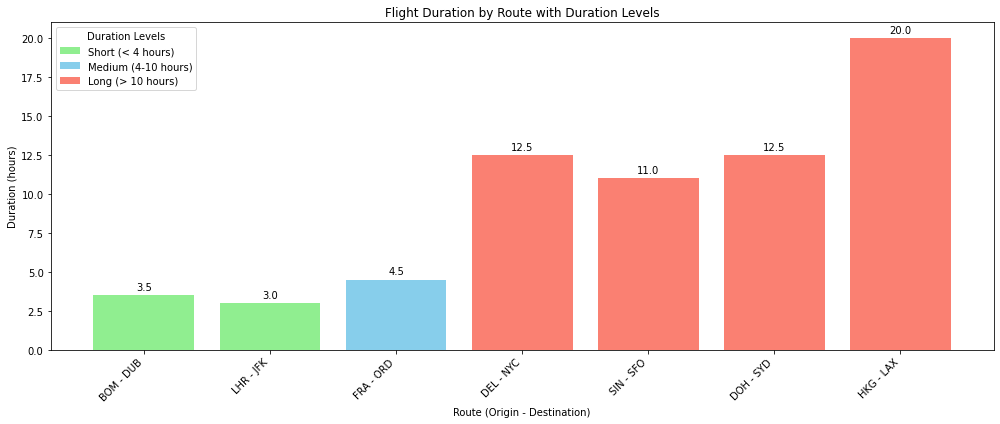

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample Data (assuming spark_df is already defined)
flight_data = spark_df.select("Origin", "Destination", "Duration").toPandas()

# Combine Origin and Destination in the x-axis label
flight_data["Route"] = flight_data["Origin"] + " - " + flight_data["Destination"]

# Define Duration Levels
def get_duration_level(duration):
    if duration <= 4:
        return 'Short (< 4 hours)'
    elif duration <= 10:
        return 'Medium (4-10 hours)'
    else:
        return 'Long (> 10 hours)'

# Apply the function to categorize the data into levels
flight_data['Duration_Level'] = flight_data['Duration'].apply(get_duration_level)

# Plot the data with color based on Duration Level
plt.figure(figsize=(14, 6))

# Color mapping based on Duration_Level
colors = {'Short (< 4 hours)': 'lightgreen', 'Medium (4-10 hours)': 'skyblue', 'Long (> 10 hours)': 'salmon'}

# Plot each level with a different color
for level, color in colors.items():
    subset = flight_data[flight_data['Duration_Level'] == level]
    bars = plt.bar(subset['Route'], subset['Duration'], label=level, color=color)
    
    # Add duration value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f'{yval:.1f}', ha='center', va='bottom', fontsize=10)

plt.title("Flight Duration by Route with Duration Levels")
plt.xlabel("Route (Origin - Destination)")
plt.ylabel("Duration (hours)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Duration Levels")
plt.tight_layout()
plt.show()


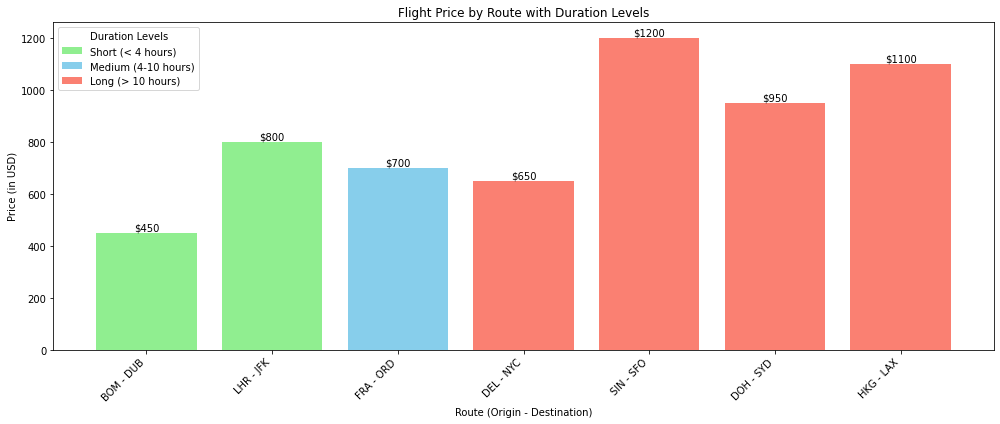

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample Data (assuming spark_df is already defined)
flight_data = spark_df.select("Origin", "Destination", "Duration", "Price").toPandas()

# Combine Origin and Destination in the x-axis label
flight_data["Route"] = flight_data["Origin"] + " - " + flight_data["Destination"]

# Define Duration Levels
def get_duration_level(duration):
    if duration <= 4:
        return 'Short (< 4 hours)'
    elif duration <= 10:
        return 'Medium (4-10 hours)'
    else:
        return 'Long (> 10 hours)'

# Apply the function to categorize the data into levels
flight_data['Duration_Level'] = flight_data['Duration'].apply(get_duration_level)

# Plot the data with color based on Duration Level
plt.figure(figsize=(14, 6))

# Color mapping based on Duration_Level
colors = {'Short (< 4 hours)': 'lightgreen', 'Medium (4-10 hours)': 'skyblue', 'Long (> 10 hours)': 'salmon'}

# Plot each level with a different color
for level, color in colors.items():
    subset = flight_data[flight_data['Duration_Level'] == level]
    bars = plt.bar(subset['Route'], subset['Price'], label=level, color=color)
    
    # Add price value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f'${yval:.0f}', ha='center', va='bottom', fontsize=10)

plt.title("Flight Price by Route with Duration Levels")
plt.xlabel("Route (Origin - Destination)")
plt.ylabel("Price (in USD)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Duration Levels")
plt.tight_layout()
plt.show()


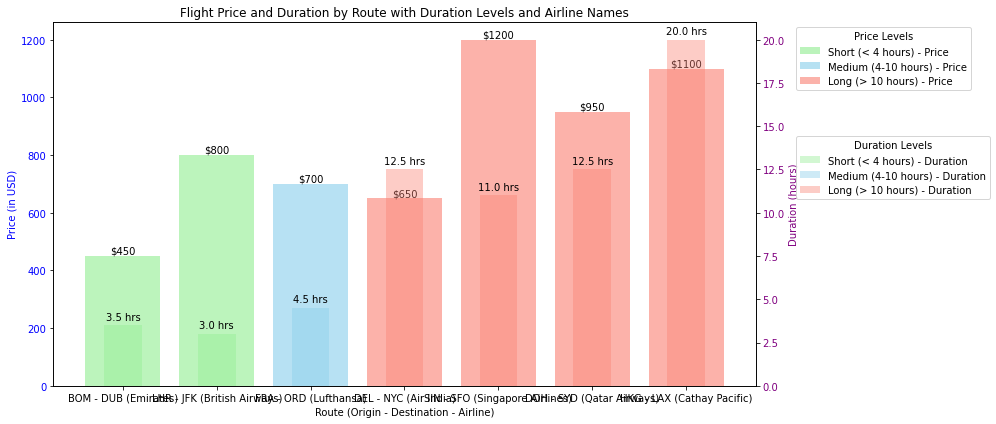

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample Data (assuming spark_df is already defined)
flight_data = spark_df.select("Origin", "Destination", "Duration", "Price", "Airline").toPandas()

# Combine Origin, Destination, and Airline in the x-axis label
flight_data["Route"] = flight_data["Origin"] + " - " + flight_data["Destination"] + " (" + flight_data["Airline"] + ")"

# Define Duration Levels
def get_duration_level(duration):
    if duration <= 4:
        return 'Short (< 4 hours)'
    elif duration <= 10:
        return 'Medium (4-10 hours)'
    else:
        return 'Long (> 10 hours)'

# Apply the function to categorize the data into levels
flight_data['Duration_Level'] = flight_data['Duration'].apply(get_duration_level)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Color mapping based on Duration_Level
colors = {'Short (< 4 hours)': 'lightgreen', 'Medium (4-10 hours)': 'skyblue', 'Long (> 10 hours)': 'salmon'}

# Plot Price data (left y-axis)
for level, color in colors.items():
    subset = flight_data[flight_data['Duration_Level'] == level]
    bars = ax1.bar(subset['Route'], subset['Price'], label=f"{level} - Price", color=color, alpha=0.6)
    
    # Add price value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f'${yval:.0f}', ha='center', va='bottom', fontsize=10)

# Create second y-axis for Duration (right y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Duration (hours)", color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Plot Duration data (right y-axis)
for level, color in colors.items():
    subset = flight_data[flight_data['Duration_Level'] == level]
    bars = ax2.bar(subset['Route'], subset['Duration'], label=f"{level} - Duration", color=color, alpha=0.4, width=0.4, align='center')
    
    # Add duration value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f'{yval:.1f} hrs', ha='center', va='bottom', fontsize=10)

# Title and labels
ax1.set_title("Flight Price and Duration by Route with Duration Levels and Airline Names")
ax1.set_xlabel("Route (Origin - Destination - Airline)")
ax1.set_ylabel("Price (in USD)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add legends
ax1.legend(title="Price Levels", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title="Duration Levels", bbox_to_anchor=(1.05, 0.7), loc='upper left')

# Layout and show plot
plt.tight_layout()
plt.show()


# **Key Pointers:**
- British Airways charges higher for the shorter route LHR - JFK compared to the medium-length route FRA - ORD. Similarly, Singapore Airlines follows a similar pricing pattern.